In [ ]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import metrics

## 1. Data Preparation

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
## Full features
X_train_full = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SCAM/X_train_fSC.pkl')
X_test_full = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SCAM/X_test_fSC.pkl')
y_train_full = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SCAM/y_train_fSC.pkl')
y_test_full = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SCAM/y_test_fSC.pkl')

df_train_full = pd.concat([X_train_full, y_train_full], axis=1)
df_test_full = pd.concat([X_test_full, y_test_full], axis=1)

## Vanilla features
X_train_v = X_train_full.drop(['text', 'cleaned_text', 'cleaned_text_full'], axis=1)
X_test_v = X_test_full.drop(['text', 'cleaned_text', 'cleaned_text_full'], axis=1)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_v), index = X_train_v.index, columns = X_train_v.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_v), index = X_test_v.index, columns = X_test_v.columns)

## Target Label
y_train = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SCAM/y_train_fSC.pkl')
y_test = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/Full Text SCAM/y_test_fSC.pkl')

## TF-IDF
X_train_tfidf = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/TFIDF SCAM/X_train_tfSC.pkl')
X_test_tfidf = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/TFIDF SCAM/X_test_tfSC.pkl')

## TF-IDF GloVe
X_train_tfidf_glove = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/TFIDF Glove SCAM/X_train_tfglSC.pkl')
X_test_tfidf_glove = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/TFIDF Glove SCAM/X_test_tfglSC.pkl')

## TF-IDF FastText (cc)
X_train_tfidf_cc = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/TFIDF CC SCAM/X_train_tfccSC.pkl')
X_test_tfidf_cc = pd.read_pickle('/content/gdrive/My Drive/BT4222/Codes/Cleaned Input Data/TFIDF CC SCAM/X_test_tfccSC.pkl')

In [ ]:
X_train_v.head()

,duplicate_words_count,upper_char_count,lower_char_count,special_char_count,capital_char_max_adj_count,url_count,consec_exclamation_count,consec_question_count,capital_word_count,all_capital_word_count,all_digit_word_count,single_letter_word_count,single_digit_word_count,question_count,colon_count,at_count,dollar_count,exclamation_count,length,capital_char_percentage,exclamation_percentage,dollar_percentage,special_char_percentage,lower_char_percentage,question_percentage,colon_percentage
1364,22,19,718,31,1,1,0,0,17,0,2,0,0,1,2,0,0,0,919,0.020675,0.000000,0.000000,0.033732,0.781284,0.001088,0.002176
2382,1,28,241,26,4,0,0,0,24,2,2,0,1,0,3,0,2,2,347,0.080692,0.005764,0.005764,0.074928,0.694524,0.000000,0.008646
612,26,165,740,51,11,0,0,0,58,21,9,4,0,2,11,0,0,0,1182,0.139594,0.000000,0.000000,0.043147,0.626058,0.001692,0.009306
2308,3,269,0,23,11,0,2,0,47,47,1,0,2,0,0,0,0,6,348,0.772989,0.017241,0.000000,0.066092,0.000000,0.000000,0.000000
1742,21,150,805,125,7,0,0,0,113,13,5,5,2,2,7,0,0,8,1298,0.115562,0.006163,0.000000,0.096302,0.620185,0.001541,0.005393


## 2. Check for Class Balance

### 2.1 Data Preparation

In [ ]:
def autolabel(rects, title, labels=None, height_factor=1.05):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if labels is not None:
            try:
                label = labels[i]
            except (TypeError, KeyError):
                label = ' '
        else:
            label = '%d' % int(height)
        ax.set_title(title, fontsize=20)
        ax.text(rect.get_x() + rect.get_width()/2., height_factor*height,
                '{}'.format(label), fontsize=18, color="white",
                ha='center', va='bottom')

### 2.2 Class Balance: Train Data

In [ ]:
981/(538+981)

0.6458196181698486

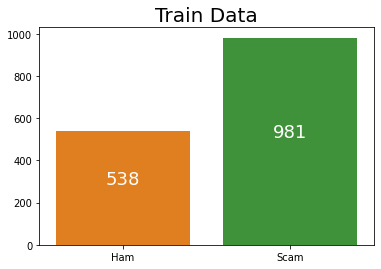

In [ ]:
data_balance = {'labels': ['Ham', 'Scam'],
       'count': [len(y_train_full[y_train_full==0]), len(y_train_full[y_train_full==1])]}
ax = sns.barplot(data=data_balance, x='labels', y='count',palette="Paired_r")
autolabel(ax.patches, "Train Data", labels=data_balance['count'], height_factor=0.5)

### 2.3 Class Balance: Test Data

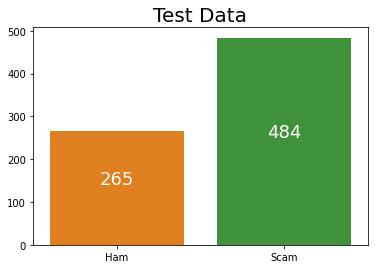

In [ ]:
data_balance = {'labels': ['Ham', 'Scam'],
       'count': [len(y_test_full[y_test_full==0]), len(y_test_full[y_test_full==1])]}
ax = sns.barplot(data=data_balance, x='labels', y='count',palette="Paired_r")
autolabel(ax.patches, "Test Data", labels=data_balance['count'], height_factor=0.5)

## 3. Check for Feature Importance

### 3.1 Preparation

In [ ]:
features = X_train_v.columns

In [ ]:
# Define Feature Importance Function
def base_model_ev(model, X_test, y_test, features, type):
  
  # Print Accuracy Score
  print("--- Model Accuracy Score ---\n{0}\n\n".format(metrics.accuracy_score(y_test, model.predict(X_test))))
  
  # Print Feature Importance Table
  df = pd.DataFrame(columns = ['features', 'importance'])
  df['features'] = features
  if(type == 'lr'):
    df['importance'] = model.coef_[0].tolist()
  elif(type == 'rf'):
    df['importance'] = model.feature_importances_.tolist()
  else:
    print("Please Input Acceptable Model Types")
    return 0
  df = df.sort_values('importance', ascending = False)
  print("--- Feature Importance Table ---\n{0}\n\n".format(df))

  # Plot Feature Importance Bar Chart
  print("--- Feature Importance BarChart ---\n".format(df))
  ax = df['importance'].plot.bar(figsize=(8,8),title='Feature Importance Score')
  ax.set_xticks(range(len(df['features'])))
  ax.set_xticklabels(df['features'])
  ax.axhline(y=0.0, color='black', linestyle='-', linewidth=2)

### 3.2 Train Logistic Regression Base Model

--- Model Accuracy Score ---
0.897196261682243


--- Feature Importance Table ---
                      features  importance
23       lower_char_percentage    2.909193
13              question_count    0.718609
15                    at_count    0.614391
5                    url_count    0.405772
16                dollar_count    0.086415
0        duplicate_words_count    0.069833
4   capital_char_max_adj_count    0.045755
18                      length    0.040775
20      exclamation_percentage    0.006791
9       all_capital_word_count    0.005154
21           dollar_percentage   -0.000748
14                 colon_count   -0.016144
25            colon_percentage   -0.023790
8           capital_word_count   -0.029238
3           special_char_count   -0.033166
1             upper_char_count   -0.037445
2             lower_char_count   -0.043319
24         question_percentage   -0.047574
10        all_digit_word_count   -0.152528
11    single_letter_word_count   -0.279198
17           ex

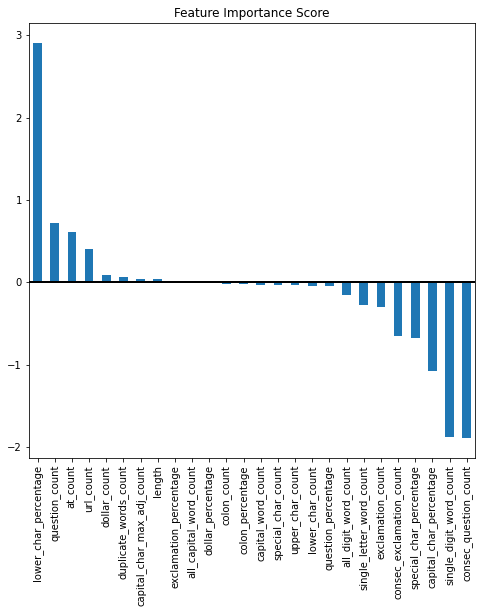

In [ ]:
model = LogisticRegression(solver='lbfgs', max_iter=10000) # needed to increase max_iter to reach convergence
model.fit(X_train_v,  y_train_full)
base_model_ev(model, X_test_v, y_test_full, features, 'lr')

### 3.3 Train Random Forest Base Model

--- Model Accuracy Score ---
0.9439252336448598


--- Feature Importance Table ---
                      features  importance
18                      length    0.138179
0        duplicate_words_count    0.116617
2             lower_char_count    0.097534
12     single_digit_word_count    0.093689
22     special_char_percentage    0.092273
19     capital_char_percentage    0.045624
3           special_char_count    0.042659
1             upper_char_count    0.042278
23       lower_char_percentage    0.038154
8           capital_word_count    0.035450
21           dollar_percentage    0.031622
25            colon_percentage    0.030907
20      exclamation_percentage    0.027943
5                    url_count    0.027298
11    single_letter_word_count    0.023756
14                 colon_count    0.017799
4   capital_char_max_adj_count    0.015800
9       all_capital_word_count    0.015277
17           exclamation_count    0.013231
10        all_digit_word_count    0.013012
15            

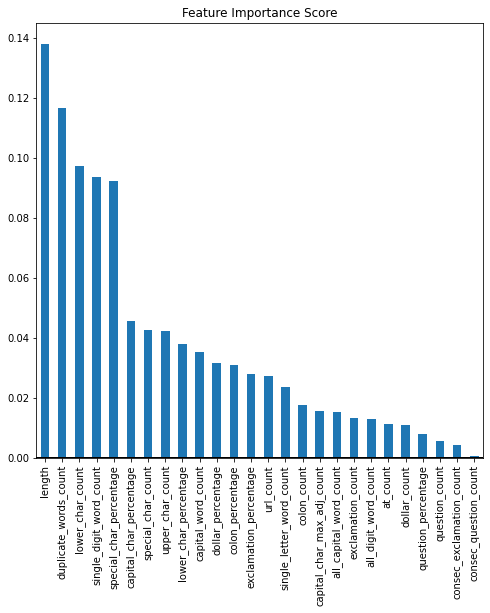

In [ ]:
model = RandomForestClassifier()
model.fit(X_train_v,  y_train_full)
base_model_ev(model, X_test_v, y_test_full, features, 'rf')

## 4. Feature Comparison BarChart

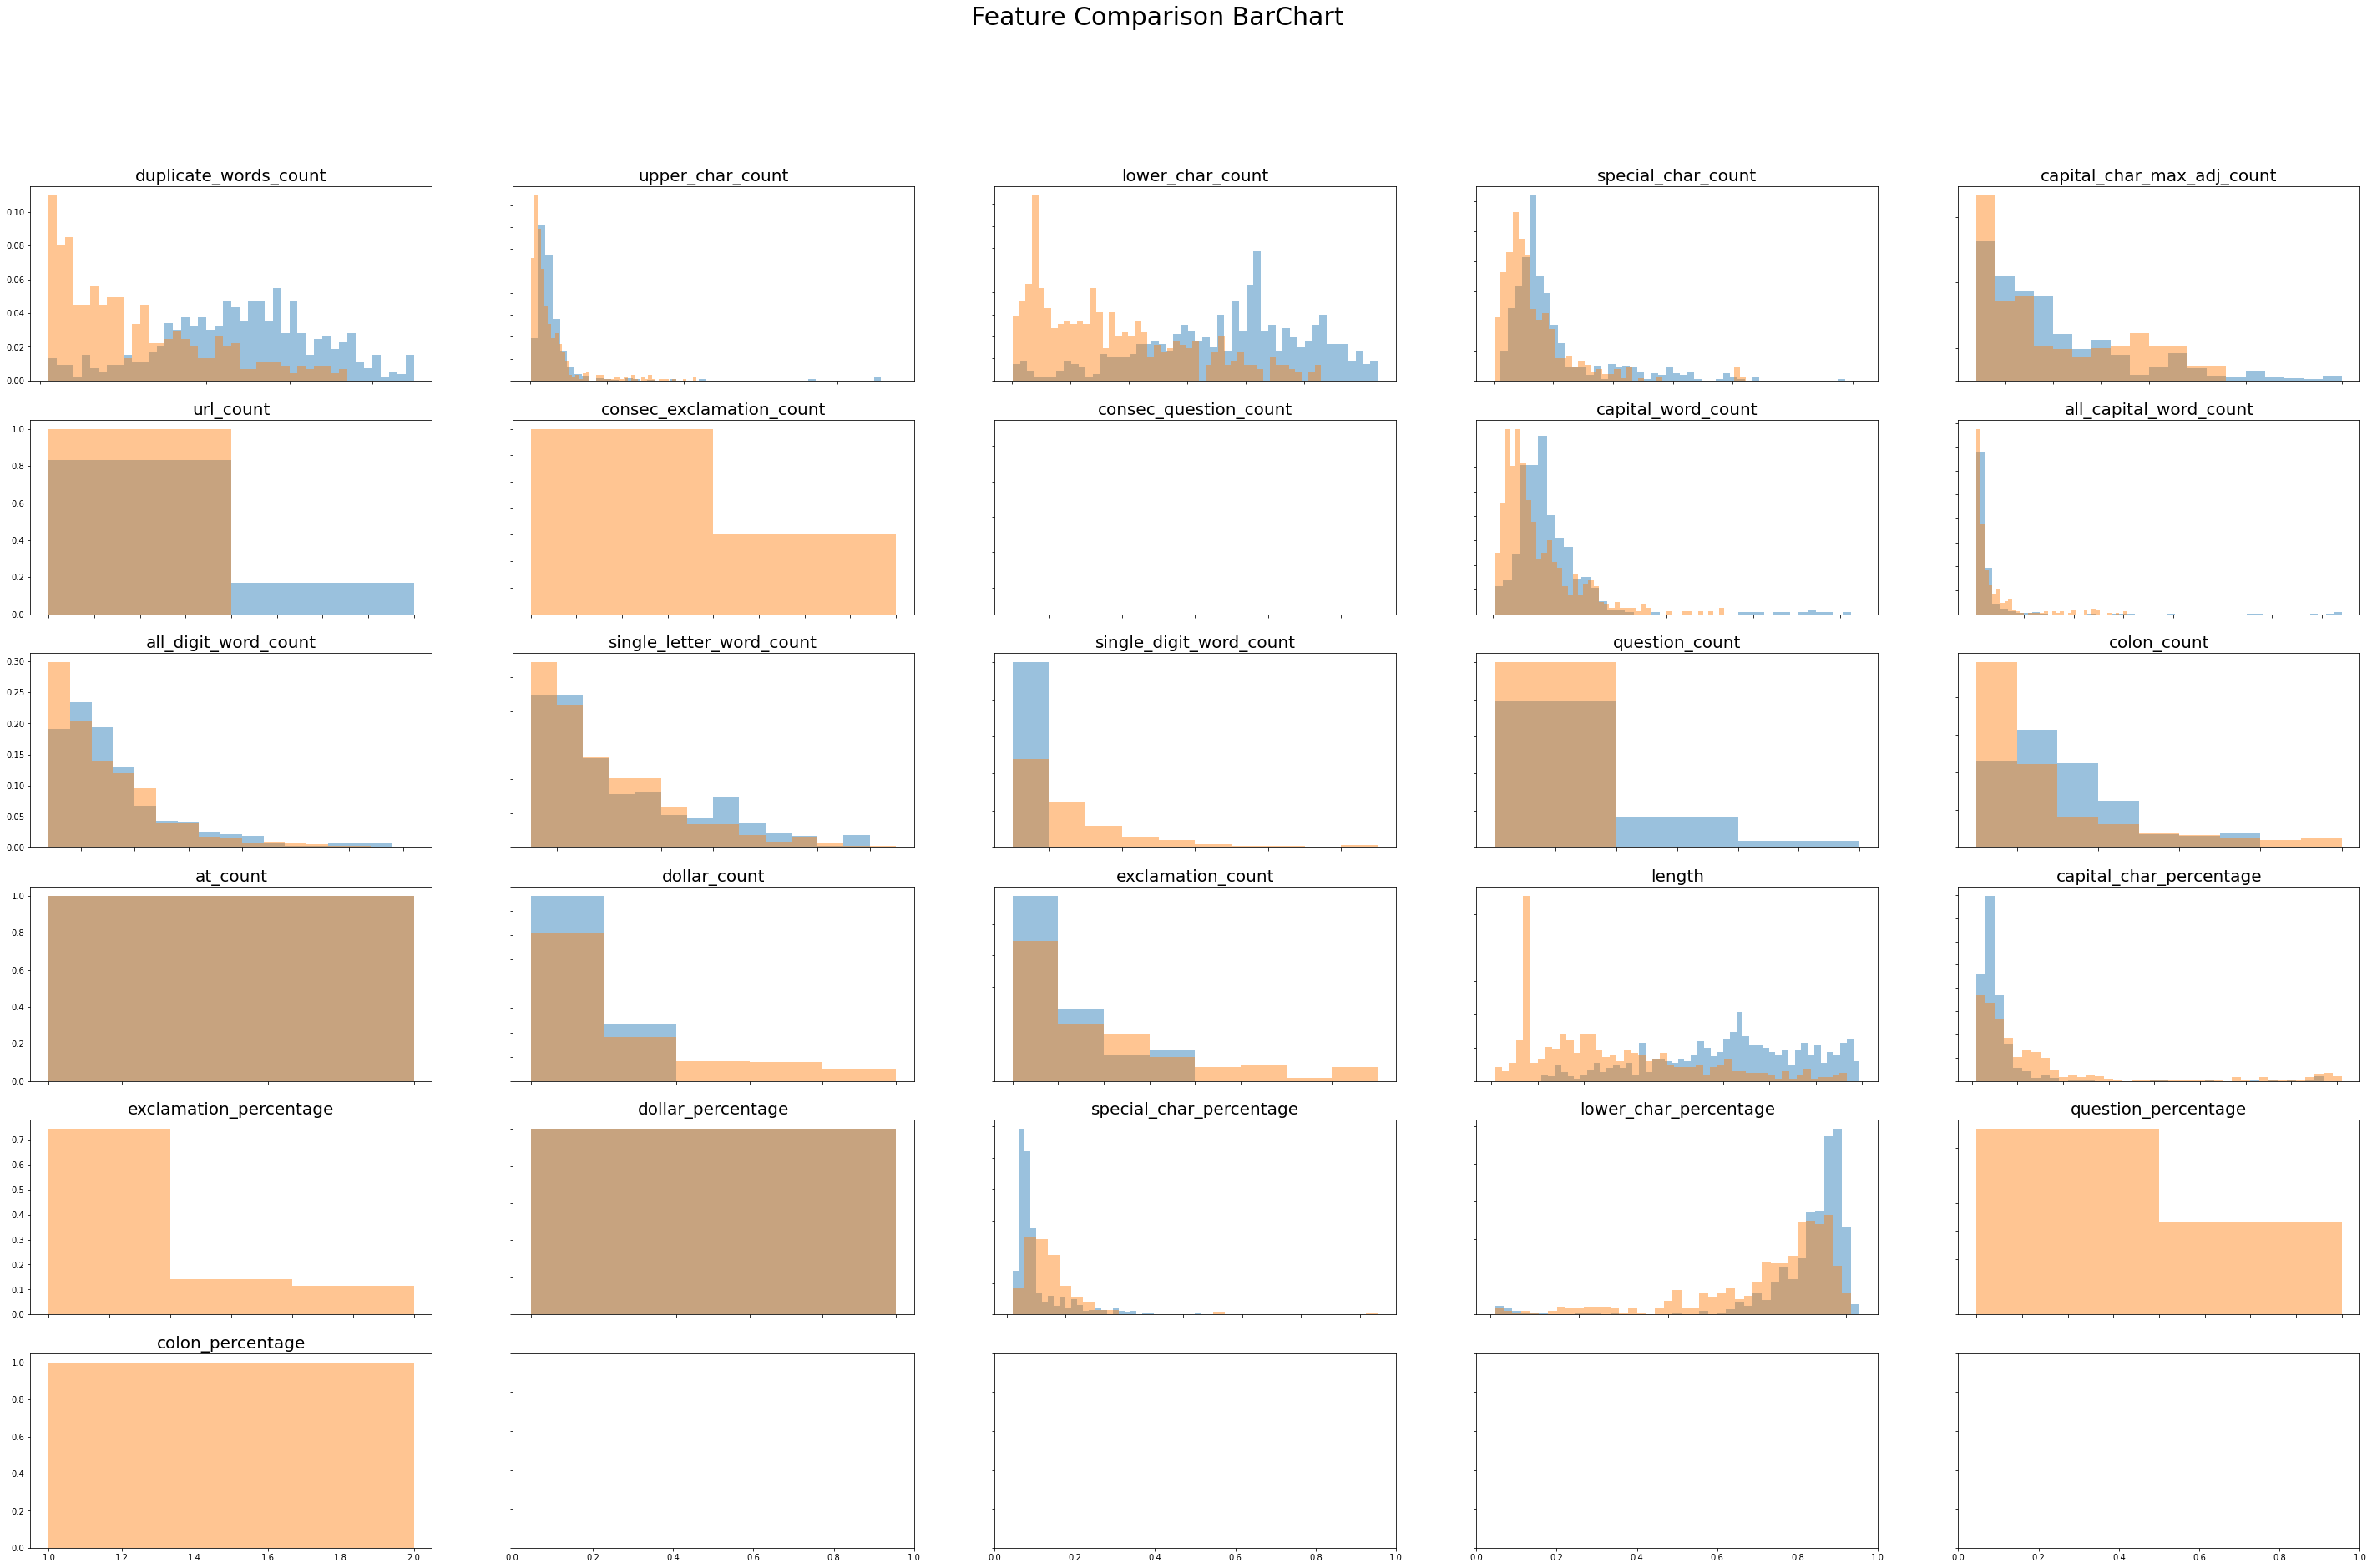

In [ ]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15), (ax16, ax17, ax18, ax19, ax20), (ax21, ax22, ax23, ax24, ax25), (ax26, ax27, ax28, ax29, ax30)) = plt.subplots(6, 5, figsize=(50, 30))
plots = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, ax21, ax22, ax23, ax24, ax25, ax26]

# Prepare Datasets
df_positive = df_train_full[df_train_full.iloc[:,-1]==1]
df_negative = df_train_full[df_train_full.iloc[:,-1]==0]
df_positive = df_positive.drop(['text', 'cleaned_text', 'cleaned_text_full', 'scam'], axis=1)
df_negative = df_negative.drop(['text', 'cleaned_text', 'cleaned_text_full', 'scam'], axis=1)

# Downsampling
if(len(df_positive) > len(df_negative)):
  df_positive = df_positive.sample(len(df_negative))
elif(len(df_positive) > len(df_negative)):
  df_negative = df_negative.sample(len(df_positive))

# Plot BarChart
fig.suptitle('Feature Comparison BarChart', fontsize=30)

for i in range(len(plots)):
  # Get Data
  df_1 = df_positive.iloc[:,i]
  df_2 = df_negative.iloc[:,i]
  colname = df_positive.columns[i]

  # Handle Percentage Data
  if("percentage" in colname):
    df_1 = df_1 * 100
    df_2 = df_2 * 100

  # Set Bin Range
  df_1_bin_max = math.ceil(np.percentile(df_1, 99)) # Use 99% to prevent outlier from skewing the graph
  df_1_bin_min = max(math.ceil(min(df_1)), 1)
  df_2_bin_max = math.ceil(np.percentile(df_2, 99))
  df_2_bin_min = max(math.ceil(min(df_2)), 1)

  # Set Bin Width
  binwidth_1 = max(math.ceil((df_1_bin_max - df_1_bin_min)/50), 1)
  binwidth_2 = max(math.ceil((df_2_bin_max - df_2_bin_min)/50),1)
  
  # Plot Graphs
  plots[i].hist(df_1, density=True, bins=range(df_1_bin_min, df_1_bin_max + binwidth_1, binwidth_1), histtype='bar', stacked=True, alpha=0.45)
  plots[i].hist(df_2, density=True, bins=range(df_2_bin_min, df_2_bin_max + binwidth_2, binwidth_2), histtype='bar', stacked=True, alpha=0.45)
  plots[i].set_title(colname, fontsize=20)

for ax in fig.get_axes():
    ax.label_outer()

In [ ]:
# Code for Checking Individual BarChart
# x = scam.length
# y = nonscam_balanced.length
# fig, ax = plt.subplots()

# sns.distplot(x, bins=range(1, 3000, 25), ax=ax, kde=False, label = 'scam' )
# sns.distplot(y, bins=range(1, 3000, 25), ax=ax, kde=False, label = 'non-scam')
# ax.set_xlim([0, 1750])

# ax.legend()

## 5. Compare WordCloud

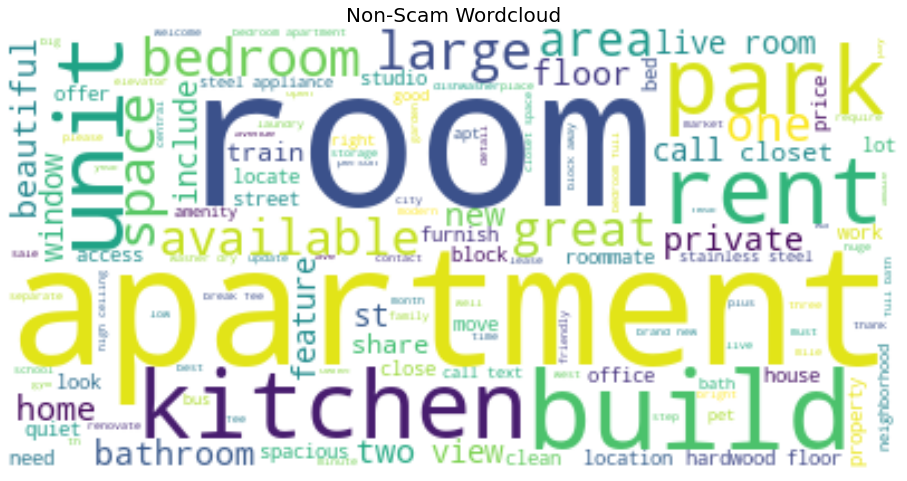

<Figure size 432x288 with 0 Axes>

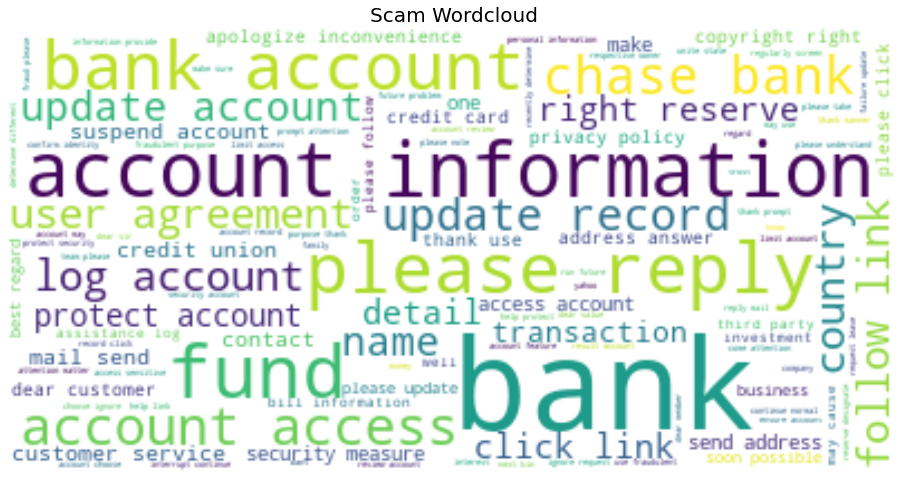

<Figure size 432x288 with 0 Axes>

In [ ]:
def scam_text_for_cloud(label):
    text = ' '.join(list(df_train_full[df_train_full['scam'] == label]['cleaned_text']))
    return text

for label in [0, 1]:
    wordcloud = WordCloud(background_color="white").generate(scam_text_for_cloud(label))

    plt.figure(figsize=(16, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(str(['Non-Scam' if label == 0 else 'Scam'][0] ) + ' Wordcloud', fontsize=20)
    plt.show()

    plt.savefig('wc.png', dpi=300)

## 6. Check Data Separability with PCA 2D

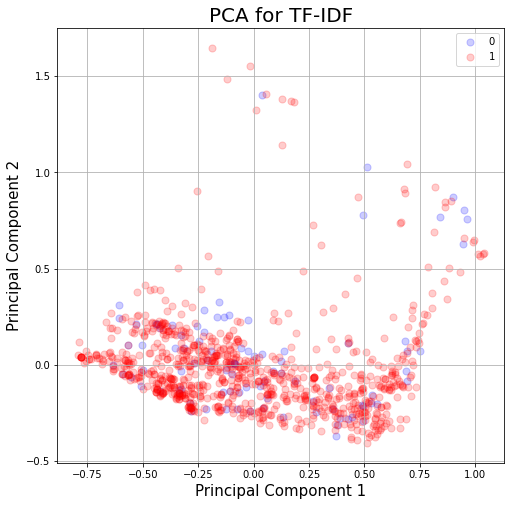

In [ ]:
pca = PCA(n_components = 2)
principalComponents  = pca.fit_transform(X_train_tfidf)
principalDf = pd.DataFrame(data = principalComponents , columns = ['PC1', 'PC2'])
finalDf = pd.concat([principalDf, y_train], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA for TF-IDF', fontsize = 20)

targets = [0, 1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['scam'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50
               , alpha = 0.2)
ax.legend(targets)
ax.grid()
plt.show()

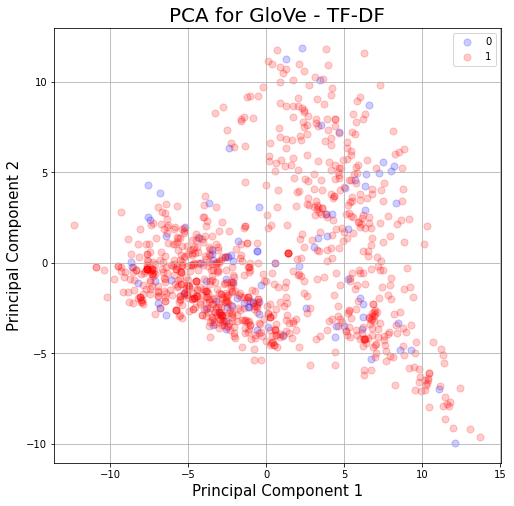

In [ ]:
pca = PCA(n_components = 2)
principalComponents  = pca.fit_transform(X_train_tfidf_glove)
principalDf = pd.DataFrame(data = principalComponents , columns = ['PC1', 'PC2'])
finalDf = pd.concat([principalDf, y_train], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA for GloVe - TF-DF', fontsize = 20)

targets = [0, 1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['scam'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50
               , alpha = 0.2)
ax.legend(targets)
ax.grid()
plt.show()

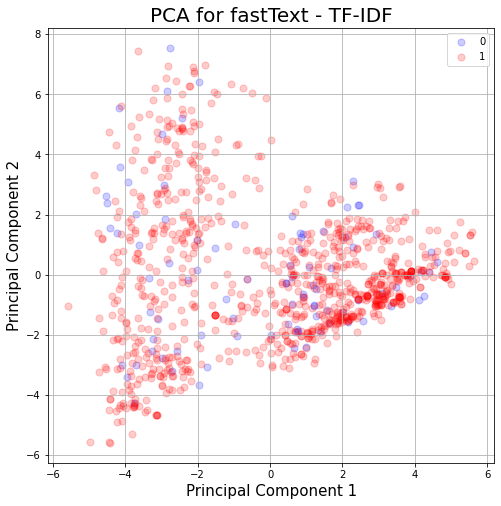

In [ ]:
pca = PCA(n_components = 3)
principalComponents  = pca.fit_transform(X_train_tfidf_cc)
principalDf = pd.DataFrame(data = principalComponents , columns = ['PC1', 'PC2', 'PC3'])
finalDf = pd.concat([principalDf, y_train], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA for fastText - TF-IDF', fontsize = 20)

targets = [0, 1]
colors = ['b', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['scam'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50
               , alpha = 0.2)
ax.legend(targets)
ax.grid()
plt.show()

## 7. Check Data Separability with PCA 3D

In [ ]:
pca = PCA(n_components=3)
components = pca.fit_transform(X_train_tfidf)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_train,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={0: 'Ham', 1: 'Spam'},
    opacity=0.5,
)
fig.show()

In [ ]:
pca = PCA(n_components=3)
components = pca.fit_transform(X_train_tfidf_glove)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_train,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={0: 'Ham', 1: 'Spam'},
    opacity=0.5,
)
fig.show()

In [ ]:
pca = PCA(n_components=3)
components = pca.fit_transform(X_train_tfidf_cc)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_train,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={0: 'Ham', 1: 'Spam'},
    opacity=0.5,
)
fig.show()